### Import Libraries

In [174]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Read in Dataset

In [175]:
df = pd.read_csv('fbdh1.csv')

In [176]:
df.head()

,Flow,D1,D2,P1,P2,dD1,dD2,dP1,dP2
0,-16.69,99.49,-145.71,48.04,-15.90,81.17,12.26,36.71,2.21
1,-16.23,172.78,-118.66,79.84,-11.94,80.09,18.49,35.48,2.91
2,-15.54,242.66,-81.28,109.77,-7.75,75.74,24.65,33.03,3.26
3,-15.17,316.42,-55.50,140.84,-5.30,74.07,28.43,31.89,3.37
4,-14.51,392.40,-31.67,171.92,-1.24,73.96,29.70,31.32,3.68


In [177]:
def label_fix(label):
    if label < -7.5:
        return 0
    elif label > 7.5:
        return 1
    else:
        return 2

df['Class'] = df['Flow'].apply(label_fix)

In [178]:
df.head()

,Flow,D1,D2,P1,P2,dD1,dD2,dP1,dP2,Class
0,-16.69,99.49,-145.71,48.04,-15.90,81.17,12.26,36.71,2.21,0
1,-16.23,172.78,-118.66,79.84,-11.94,80.09,18.49,35.48,2.91,0
2,-15.54,242.66,-81.28,109.77,-7.75,75.74,24.65,33.03,3.26,0
3,-15.17,316.42,-55.50,140.84,-5.30,74.07,28.43,31.89,3.37,0
4,-14.51,392.40,-31.67,171.92,-1.24,73.96,29.70,31.32,3.68,0


In [171]:
# Create Function to Gather Data into Overlapping Windows
# Cuts data into size compatible with window length and step size
# Gathers data into results output
# Takes the mode of the classes for each window and saves in classes output

def windowData(df, windowSize, stepSize):
    
    df.reset_index(drop = True, inplace = True)
    new_data = df
    
    for i in range(len(new_data) - windowSize, len(new_data)):
        
        if (i - windowSize) % stepSize  == 0:
            new_data = df.truncate(after = i - 1)
    
    windf = new_data
    
    length = len(windf['D1'])
    
    results = np.zeros([int((length - windowSize) / stepSize), windowSize, 8])
    classes = np.zeros([int((length - windowSize) / stepSize), 1])
    
    for j in range(0, results.shape[0]):
        
        classData = np.zeros([windowSize, 1])
        
        for i in range(0, windowSize):
            
            results[j][i] = [windf['D1'][i + (j * stepSize)], 
                                 windf['D2'][i + (j * stepSize)], 
                                 windf['P1'][i + (j * stepSize)], 
                                 windf['P2'][i + (j * stepSize)], 
                                 windf['dD1'][i + (j * stepSize)], 
                                 windf['dD2'][i + (j * stepSize)], 
                                 windf['dP1'][i + (j * stepSize)], 
                                 windf['dP2'][i + (j * stepSize)]]
            
            classData[i] = windf['Class'][i + (j * stepSize)]
            
        classes[j] = int(stats.mode(classData)[0])
        
    return results, classes

### Create Feature Matrix / Gather Training and Testing Data

In [169]:
df.head()

,Flow,D1,D2,P1,P2,dD1,dD2,dP1,dP2,Class
0,-16.69,99.49,-145.71,48.04,-15.90,81.17,12.26,36.71,2.21,0
1,-16.23,172.78,-118.66,79.84,-11.94,80.09,18.49,35.48,2.91,0
2,-15.54,242.66,-81.28,109.77,-7.75,75.74,24.65,33.03,3.26,0
3,-15.17,316.42,-55.50,140.84,-5.30,74.07,28.43,31.89,3.37,0
4,-14.51,392.40,-31.67,171.92,-1.24,73.96,29.70,31.32,3.68,0


In [181]:
scaleData = df.drop('Flow', axis = 1)
scaleData.drop('Class', axis = 1, inplace = True)

scaler = StandardScaler()
scaler.fit(scaleData)
scaled_features = scaler.transform(scaleData)

X = pd.DataFrame(scaled_features, columns = df.columns[1:9])
X['Class'] = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [182]:
trainX, trainY = windowData(X_train, 4, 1)
testX, testY = windowData(X_test, 4, 1)

In [183]:
trainX.shape

(4659, 4, 8)

In [184]:
trainY.shape

(4659, 1)

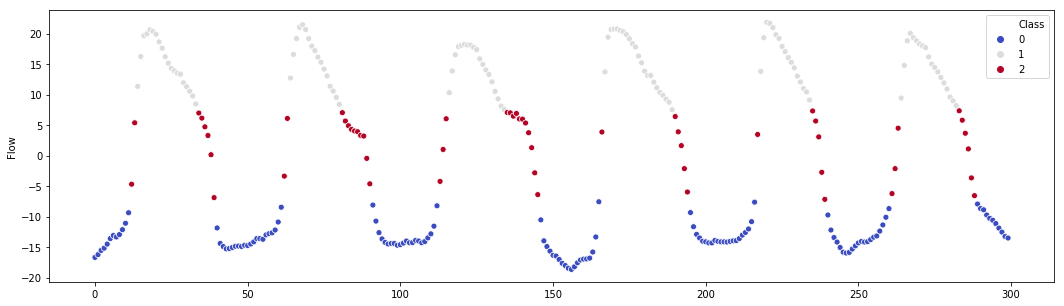

In [179]:
fig = plt.figure(figsize = (18, 5))
sns.scatterplot(y = df['Flow'][0:300], x = range(0, 300), hue = df['Class'][0:300], palette = 'coolwarm')

### Develop LSTM Model

In [185]:
time_steps = trainX.shape[1]
features = trainX.shape[2]

LSTM = keras.Sequential()
LSTM.add(keras.layers.LSTM(175, input_shape = (time_steps, features)))
LSTM.add(keras.layers.Dropout(0.3))
LSTM.add(keras.layers.Dense(50, activation = tf.nn.relu))
LSTM.add(keras.layers.Dropout(0.4))
LSTM.add(keras.layers.Dense(3, activation = tf.nn.softmax))
LSTM.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

LSTM.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 175)               128800    
_________________________________________________________________
dropout_20 (Dropout)         (None, 175)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                8800      
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 153       
Total params: 137,753
Trainable params: 137,753
Non-trainable params: 0
_________________________________________________________________


In [186]:
LSTM.fit(trainX, trainY, epochs = 50)

Epoch 1/50
4659/4659 [==============================] - 2s 327us/sample - loss: 0.6626 - acc: 0.7508
Epoch 2/50
4659/4659 [==============================] - 1s 213us/sample - loss: 0.5289 - acc: 0.7959
Epoch 3/50
4659/4659 [==============================] - 1s 192us/sample - loss: 0.5038 - acc: 0.8036
Epoch 4/50
4659/4659 [==============================] - 1s 174us/sample - loss: 0.4779 - acc: 0.8077
Epoch 5/50
4659/4659 [==============================] - 1s 185us/sample - loss: 0.4705 - acc: 0.8135
Epoch 6/50
4659/4659 [==============================] - 1s 211us/sample - loss: 0.4583 - acc: 0.8169
Epoch 7/50
4659/4659 [==============================] - 1s 224us/sample - loss: 0.4422 - acc: 0.8244
Epoch 8/50
4659/4659 [==============================] - 1s 234us/sample - loss: 0.4301 - acc: 0.8291
Epoch 9/50
4659/4659 [==============================] - 1s 234us/sample - loss: 0.4185 - acc: 0.8317
Epoch 10/50
4659/4659 [==============================] - 1s 202us/sample - loss: 0.4100 - a

### Evaluate Model on Testing Split

In [187]:
testX.shape

(1995, 4, 8)

In [188]:
testY.shape

(1995, 1)

In [189]:
predictions = LSTM.predict(testX)

In [190]:
final_pred = []
for score in range(0, len(predictions)):
    final_pred.append(np.argmax(predictions[score]))
    
print(classification_report(testY, final_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88      1167
         1.0       0.78      0.87      0.82       671
         2.0       0.43      0.32      0.36       157

   micro avg       0.83      0.83      0.83      1995
   macro avg       0.70      0.69      0.69      1995
weighted avg       0.82      0.83      0.82      1995



### Test on New Dataset

In [152]:
# Read in dataframe
test = pd.read_csv('test_data_2.csv')
test['Class'] = test['Flow'].apply(label_fix)

scaleData_2 = test.drop('Flow', axis = 1)
scaleData_2.drop('Class', axis = 1, inplace = True)

scaler = StandardScaler()
scaler.fit(scaleData_2)
scaled_features = scaler.transform(scaleData_2)

X_1 = pd.DataFrame(scaled_features, columns = df.columns[1:9])
X_1['Class'] = test['Class']
y_1 = test['Class']

newX, newY = windowData(X_1, 4, 3)

In [153]:
test_predictions = LSTM.predict(newX)

final_pred_test = []
for score in range(0, len(test_predictions)):
    final_pred_test.append(np.argmax(test_predictions[score]))
    
print(classification_report(newY, final_pred_test))

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.85       743
         1.0       0.89      0.83      0.86       714
         2.0       0.61      0.72      0.66       214

   micro avg       0.83      0.83      0.83      1671
   macro avg       0.78      0.80      0.79      1671
weighted avg       0.83      0.83      0.83      1671

